In [1]:
#%load_ext autoreload
#%autoreload 2

In [1]:
import pyro
from pyro.optim import Adam, ClippedAdam
from pyro.infer import TraceMeanField_ELBO, TraceEnum_ELBO, TraceGraph_ELBO, Trace_ELBO

import pandas as pd
import torch

In [3]:
from locate.simulations.simulate import simulate_segment, simulate_data
from locate.simulations.utils_simulations import plot_simulations, create_input_simulations, plot_results_simulations

In [4]:
purity = .9
coverage = 100
ploidy = 2

segs = simulate_segment(only_clonal = True, 
                        purity = purity, 
                        coverage = coverage, 
                        genome_size = 30000000, 
                        segments = 3, 
                        CNA = ["2:1", "1:1", "2:2"])
snp,snv = simulate_data(segs)
data_input, snp, snv = create_input_simulations(snp, snv)

In [5]:
N = snp.shape[0]
snp['index'] = [i for i in range(N)]
bp = snp.groupby('segID').agg(min_pos=('index', 'min'), max_pos=('index', 'max')).melt(value_vars=['min_pos', 'max_pos'])
bp

,variable,value
0,min_pos,0
1,min_pos,358
2,min_pos,449
3,max_pos,357
4,max_pos,448
5,max_pos,1952


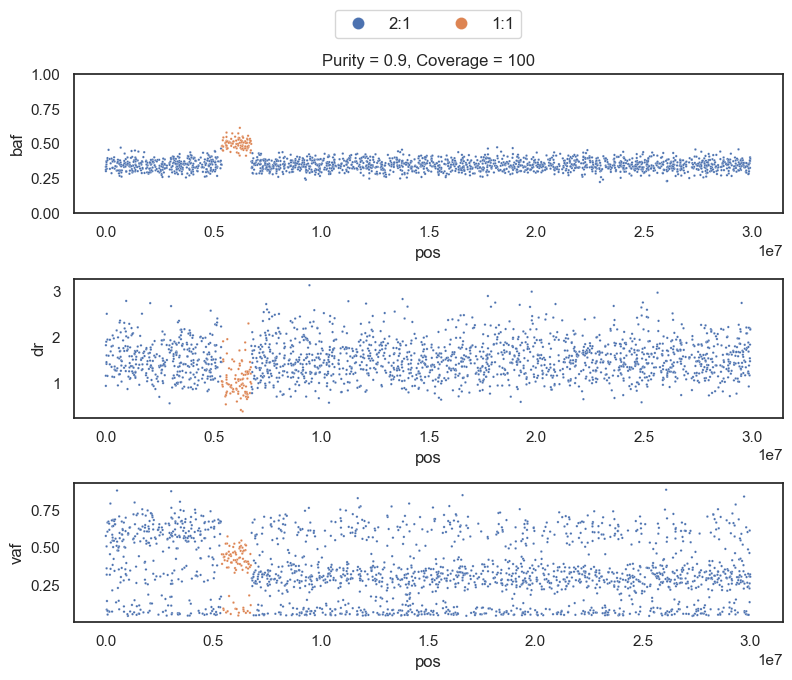

In [6]:
plot_simulations(snp, snv, purity, coverage) 

In [7]:
import locate.locate as l
from locate.models import Clonal
from locate.utils import plot_loss

In [8]:
data_input

{'baf': tensor([[0.4029],
         [0.3624],
         [0.3496],
         ...,
         [0.3107],
         [0.3572],
         [0.3322]], dtype=torch.float64),
 'dr': tensor([[1.1483],
         [0.9276],
         [1.5542],
         ...,
         [1.4810],
         [1.8728],
         [1.1276]], dtype=torch.float64),
 'vaf': tensor([[61.],
         [64.],
         [33.],
         ...,
         [ 8.],
         [11.],
         [10.]], dtype=torch.float64),
 'dp': tensor([[ 93],
         [110],
         [101],
         ...,
         [ 92],
         [101],
         [111]]),
 'dp_snp': tensor([[ 97],
         [121],
         [ 93],
         ...,
         [ 95],
         [ 85],
         [106]])}

In [12]:
locate = l.LOCATE(CUDA = False)

locate.set_model(Clonal)
locate.set_optimizer(ClippedAdam)
locate.set_loss(TraceEnum_ELBO)
locate.initialize_model({"baf": data_input["baf"],
                         "dr": data_input["dr"], 
                         "dp_snp": data_input["dp_snp"], 
                         "vaf": None, 
                         "dp": None
                         })

locate.set_model_params({"jumping_prob" : 1e-6,
                         "fix_purity": False,
                         "prior_purity": purity,
                         "prior_ploidy": ploidy,
                         "scaling_factors": [1,1,1],
                         "prior_bp": None,
                         'init_probs': torch.tensor([0.1, 0.1, 0.1, 0.1, 0.1])})

In [13]:
ll = locate.run(steps = 200, param_optimizer = {"lr" : 0.05})

tensor([[1.0000e+00, 1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06],
        [1.0000e-06, 1.0000e+00, 1.0000e-06, 1.0000e-06, 1.0000e-06],
        [1.0000e-06, 1.0000e-06, 1.0000e+00, 1.0000e-06, 1.0000e-06],
        [1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e+00, 1.0000e-06],
        [1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e+00]])
tensor([[1.0000e+00, 1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06],
        [1.0000e-06, 1.0000e+00, 1.0000e-06, 1.0000e-06, 1.0000e-06],
        [1.0000e-06, 1.0000e-06, 1.0000e+00, 1.0000e-06, 1.0000e-06],
        [1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e+00, 1.0000e-06],
        [1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e+00]],
       grad_fn=<ExpandBackward0>)
tensor([[1.0000e+00, 1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06],
        [1.0000e-06, 1.0000e+00, 1.0000e-06, 1.0000e-06, 1.0000e-06],
        [1.0000e-06, 1.0000e-06, 1.0000e+00, 1.0000e-06, 1.0000e-06],
        [1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e+0

/Users/lucreziavaleriani/opt/anaconda3/envs/locate/lib/python3.11/site-packages/pyro/infer/traceenum_elbo.py:355: UserWarning: TraceEnum_ELBO found no sample sites configured for enumeration. If you want to enumerate sites, you need to @config_enumerate or set infer={"enumerate": "sequential"} or infer={"enumerate": "parallel"}? If you do not want to enumerate, consider using Trace_ELBO instead.
  warnings.warn(
ELBO: -2369.635594169  :   0%|          | 0/200 [00:00<?, ?it/s]/Users/lucreziavaleriani/opt/anaconda3/envs/locate/lib/python3.11/site-packages/pyro/infer/traceenum_elbo.py:355: UserWarning: TraceEnum_ELBO found no sample sites configured for enumeration. If you want to enumerate sites, you need to @config_enumerate or set infer={"enumerate": "sequential"} or infer={"enumerate": "parallel"}? If you do not want to enumerate, consider using Trace_ELBO instead.
  warnings.warn(
ELBO: -2654.341270884  :   6%|▌         | 11/200 [00:00<00:03, 56.15it/s]

tensor([[1.0000e+00, 9.0483e-07, 9.0483e-07, 9.0483e-07, 9.0483e-07],
        [9.0483e-07, 1.0000e+00, 9.0483e-07, 9.0483e-07, 9.0483e-07],
        [9.0483e-07, 9.0483e-07, 1.0000e+00, 9.0494e-07, 9.0483e-07],
        [9.0483e-07, 9.0483e-07, 9.0484e-07, 1.0000e+00, 9.0483e-07],
        [9.0483e-07, 9.0483e-07, 9.0483e-07, 9.0483e-07, 1.0000e+00]],
       grad_fn=<ExpandBackward0>)
tensor([[1.0000e+00, 8.1873e-07, 8.1873e-07, 8.1873e-07, 8.1873e-07],
        [8.1873e-07, 1.0000e+00, 8.1873e-07, 8.1873e-07, 8.1873e-07],
        [8.1873e-07, 8.1873e-07, 1.0000e+00, 8.1905e-07, 8.1873e-07],
        [8.1873e-07, 8.1873e-07, 8.1890e-07, 1.0000e+00, 8.1873e-07],
        [8.1873e-07, 8.1873e-07, 8.1873e-07, 8.1873e-07, 1.0000e+00]],
       grad_fn=<ExpandBackward0>)
tensor([[1.0000e+00, 7.4082e-07, 7.4082e-07, 7.4082e-07, 7.4082e-07],
        [7.4082e-07, 1.0000e+00, 7.4082e-07, 7.4082e-07, 7.4082e-07],
        [7.4082e-07, 7.4082e-07, 1.0000e+00, 7.4153e-07, 7.4082e-07],
        [7.4082e-07,

ELBO: -2704.415359600  :  14%|█▍        | 28/200 [00:00<00:02, 73.25it/s]

tensor([[1.0000e+00, 2.0190e-07, 2.0190e-07, 2.0190e-07, 2.0190e-07],
        [2.0190e-07, 1.0000e+00, 2.0190e-07, 2.0190e-07, 2.0190e-07],
        [2.0190e-07, 2.0190e-07, 1.0000e+00, 2.1951e-07, 2.0190e-07],
        [2.0193e-07, 2.0193e-07, 2.1900e-07, 1.0000e+00, 2.0193e-07],
        [2.0190e-07, 2.0190e-07, 2.0190e-07, 2.0190e-07, 1.0000e+00]],
       grad_fn=<ExpandBackward0>)
tensor([[1.0000e+00, 1.8268e-07, 1.8268e-07, 1.8268e-07, 1.8268e-07],
        [1.8268e-07, 1.0000e+00, 1.8268e-07, 1.8268e-07, 1.8268e-07],
        [1.8268e-07, 1.8268e-07, 1.0000e+00, 2.0157e-07, 1.8268e-07],
        [1.8272e-07, 1.8272e-07, 2.0097e-07, 1.0000e+00, 1.8272e-07],
        [1.8268e-07, 1.8268e-07, 1.8268e-07, 1.8268e-07, 1.0000e+00]],
       grad_fn=<ExpandBackward0>)
tensor([[1.0000e+00, 1.6530e-07, 1.6530e-07, 1.6530e-07, 1.6530e-07],
        [1.6530e-07, 1.0000e+00, 1.6530e-07, 1.6530e-07, 1.6530e-07],
        [1.6530e-07, 1.6530e-07, 1.0000e+00, 1.8534e-07, 1.6530e-07],
        [1.6533e-07,

ELBO: -2730.867993259  :  22%|██▎       | 45/200 [00:00<00:02, 71.22it/s]

tensor([[1.0000e+00, 3.6883e-08, 3.6883e-08, 3.6883e-08, 3.6883e-08],
        [3.6883e-08, 1.0000e+00, 3.6883e-08, 3.6883e-08, 3.6883e-08],
        [3.6884e-08, 3.6884e-08, 1.0000e+00, 6.1381e-08, 3.6884e-08],
        [3.6909e-08, 3.6909e-08, 5.9763e-08, 1.0000e+00, 3.6909e-08],
        [3.6883e-08, 3.6883e-08, 3.6883e-08, 3.6883e-08, 1.0000e+00]],
       grad_fn=<ExpandBackward0>)
tensor([[1.0000e+00, 3.3373e-08, 3.3373e-08, 3.3373e-08, 3.3373e-08],
        [3.3373e-08, 1.0000e+00, 3.3373e-08, 3.3373e-08, 3.3373e-08],
        [3.3374e-08, 3.3374e-08, 1.0000e+00, 5.7523e-08, 3.3374e-08],
        [3.3398e-08, 3.3398e-08, 5.5884e-08, 1.0000e+00, 3.3398e-08],
        [3.3373e-08, 3.3373e-08, 3.3373e-08, 3.3373e-08, 1.0000e+00]],
       grad_fn=<ExpandBackward0>)
tensor([[1.0000e+00, 3.0197e-08, 3.0197e-08, 3.0197e-08, 3.0197e-08],
        [3.0197e-08, 1.0000e+00, 3.0197e-08, 3.0197e-08, 3.0197e-08],
        [3.0198e-08, 3.0198e-08, 1.0000e+00, 5.3954e-08, 3.0198e-08],
        [3.0221e-08,

ELBO: -2763.404377292  :  32%|███▏      | 63/200 [00:00<00:01, 78.87it/s]

tensor([[1.0000e+00, 9.0952e-09, 9.0952e-09, 9.0952e-09, 9.0952e-09],
        [9.0952e-09, 1.0000e+00, 9.0952e-09, 9.0952e-09, 9.0952e-09],
        [9.0958e-09, 9.0958e-09, 1.0000e+00, 2.6402e-08, 9.0957e-09],
        [9.1067e-09, 9.1067e-09, 2.4883e-08, 1.0000e+00, 9.1067e-09],
        [9.0952e-09, 9.0952e-09, 9.0952e-09, 9.0951e-09, 1.0000e+00]],
       grad_fn=<ExpandBackward0>)
tensor([[1.0000e+00, 8.2297e-09, 8.2297e-09, 8.2297e-09, 8.2297e-09],
        [8.2297e-09, 1.0000e+00, 8.2297e-09, 8.2297e-09, 8.2297e-09],
        [8.2302e-09, 8.2302e-09, 1.0000e+00, 2.4963e-08, 8.2301e-09],
        [8.2404e-09, 8.2404e-09, 2.3471e-08, 1.0000e+00, 8.2404e-09],
        [8.2297e-09, 8.2297e-09, 8.2297e-09, 8.2296e-09, 1.0000e+00]],
       grad_fn=<ExpandBackward0>)
tensor([[1.0000e+00, 7.4465e-09, 7.4465e-09, 7.4465e-09, 7.4465e-09],
        [7.4465e-09, 1.0000e+00, 7.4465e-09, 7.4465e-09, 7.4465e-09],
        [7.4470e-09, 7.4470e-09, 1.0000e+00, 2.3612e-08, 7.4469e-09],
        [7.4565e-09,

ELBO: -2790.435694470  :  36%|███▌      | 71/200 [00:01<00:01, 72.35it/s]

tensor([[1.0000e+00, 1.5035e-09, 1.5035e-09, 1.5035e-09, 1.5035e-09],
        [1.5035e-09, 1.0000e+00, 1.5035e-09, 1.5035e-09, 1.5035e-09],
        [1.5036e-09, 1.5036e-09, 1.0000e+00, 1.0095e-08, 1.5036e-09],
        [1.5063e-09, 1.5063e-09, 9.1472e-09, 1.0000e+00, 1.5063e-09],
        [1.5034e-09, 1.5034e-09, 1.5034e-09, 1.5034e-09, 1.0000e+00]],
       grad_fn=<ExpandBackward0>)
tensor([[1.0000e+00, 1.3604e-09, 1.3604e-09, 1.3604e-09, 1.3604e-09],
        [1.3604e-09, 1.0000e+00, 1.3604e-09, 1.3604e-09, 1.3604e-09],
        [1.3605e-09, 1.3605e-09, 1.0000e+00, 9.5899e-09, 1.3605e-09],
        [1.3630e-09, 1.3630e-09, 8.6725e-09, 1.0000e+00, 1.3630e-09],
        [1.3604e-09, 1.3604e-09, 1.3604e-09, 1.3603e-09, 1.0000e+00]],
       grad_fn=<ExpandBackward0>)
tensor([[1.0000e+00, 1.2309e-09, 1.2309e-09, 1.2309e-09, 1.2309e-09],
        [1.2309e-09, 1.0000e+00, 1.2309e-09, 1.2309e-09, 1.2309e-09],
        [1.2310e-09, 1.2310e-09, 1.0000e+00, 9.1117e-09, 1.2310e-09],
        [1.2333e-09,

ELBO: -2820.970423973  :  44%|████▍     | 89/200 [00:01<00:01, 77.33it/s]

tensor([[1.0000e+00, 3.3547e-10, 3.3547e-10, 3.3547e-10, 3.3547e-10],
        [3.3547e-10, 1.0000e+00, 3.3547e-10, 3.3547e-10, 3.3547e-10],
        [3.3550e-10, 3.3550e-10, 1.0000e+00, 4.7337e-09, 3.3550e-10],
        [3.3625e-10, 3.3625e-10, 4.1712e-09, 1.0000e+00, 3.3625e-10],
        [3.3547e-10, 3.3547e-10, 3.3547e-10, 3.3544e-10, 1.0000e+00]],
       grad_fn=<ExpandBackward0>)
tensor([[1.0000e+00, 3.0355e-10, 3.0355e-10, 3.0355e-10, 3.0355e-10],
        [3.0355e-10, 1.0000e+00, 3.0355e-10, 3.0355e-10, 3.0355e-10],
        [3.0357e-10, 3.0357e-10, 1.0000e+00, 4.5039e-09, 3.0357e-10],
        [3.0426e-10, 3.0426e-10, 3.9618e-09, 1.0000e+00, 3.0426e-10],
        [3.0354e-10, 3.0354e-10, 3.0354e-10, 3.0352e-10, 1.0000e+00]],
       grad_fn=<ExpandBackward0>)
tensor([[1.0000e+00, 2.7466e-10, 2.7466e-10, 2.7466e-10, 2.7466e-10],
        [2.7466e-10, 1.0000e+00, 2.7466e-10, 2.7466e-10, 2.7466e-10],
        [2.7469e-10, 2.7469e-10, 1.0000e+00, 4.2855e-09, 2.7468e-10],
        [2.7531e-10,

ELBO: -2846.175102571  :  53%|█████▎    | 106/200 [00:01<00:01, 73.91it/s]

tensor([[1.0000e+00, 6.1285e-11, 6.1285e-11, 6.1285e-11, 6.1285e-11],
        [6.1285e-11, 1.0000e+00, 6.1285e-11, 6.1285e-11, 6.1285e-11],
        [6.1292e-11, 6.1292e-11, 1.0000e+00, 2.0468e-09, 6.1291e-11],
        [6.1453e-11, 6.1453e-11, 1.7523e-09, 1.0000e+00, 6.1453e-11],
        [6.1285e-11, 6.1285e-11, 6.1285e-11, 6.1278e-11, 1.0000e+00]],
       grad_fn=<ExpandBackward0>)
tensor([[1.0000e+00, 5.5453e-11, 5.5453e-11, 5.5453e-11, 5.5453e-11],
        [5.5453e-11, 1.0000e+00, 5.5453e-11, 5.5453e-11, 5.5453e-11],
        [5.5459e-11, 5.5459e-11, 1.0000e+00, 1.9491e-09, 5.5459e-11],
        [5.5606e-11, 5.5606e-11, 1.6658e-09, 1.0000e+00, 5.5606e-11],
        [5.5453e-11, 5.5453e-11, 5.5453e-11, 5.5447e-11, 1.0000e+00]],
       grad_fn=<ExpandBackward0>)
tensor([[1.0000e+00, 5.0176e-11, 5.0176e-11, 5.0176e-11, 5.0176e-11],
        [5.0176e-11, 1.0000e+00, 5.0176e-11, 5.0176e-11, 5.0176e-11],
        [5.0182e-11, 5.0182e-11, 1.0000e+00, 1.8561e-09, 5.0181e-11],
        [5.0315e-11,

ELBO: -2874.879037154  :  62%|██████▏   | 123/200 [00:01<00:00, 77.02it/s]

tensor([[1.0000e+00, 1.6702e-11, 1.6702e-11, 1.6702e-11, 1.6702e-11],
        [1.6702e-11, 1.0000e+00, 1.6702e-11, 1.6702e-11, 1.6702e-11],
        [1.6704e-11, 1.6704e-11, 1.0000e+00, 1.0861e-09, 1.6704e-11],
        [1.6752e-11, 1.6752e-11, 9.0975e-10, 1.0000e+00, 1.6752e-11],
        [1.6702e-11, 1.6702e-11, 1.6702e-11, 1.6700e-11, 1.0000e+00]],
       grad_fn=<ExpandBackward0>)
tensor([[1.0000e+00, 1.5113e-11, 1.5113e-11, 1.5113e-11, 1.5113e-11],
        [1.5113e-11, 1.0000e+00, 1.5113e-11, 1.5113e-11, 1.5113e-11],
        [1.5115e-11, 1.5115e-11, 1.0000e+00, 1.0346e-09, 1.5115e-11],
        [1.5158e-11, 1.5158e-11, 8.6515e-10, 1.0000e+00, 1.5158e-11],
        [1.5113e-11, 1.5113e-11, 1.5113e-11, 1.5111e-11, 1.0000e+00]],
       grad_fn=<ExpandBackward0>)
tensor([[1.0000e+00, 1.3675e-11, 1.3675e-11, 1.3675e-11, 1.3675e-11],
        [1.3675e-11, 1.0000e+00, 1.3675e-11, 1.3675e-11, 1.3675e-11],
        [1.3676e-11, 1.3676e-11, 1.0000e+00, 9.8556e-10, 1.3676e-11],
        [1.3716e-11,

ELBO: -2898.325678021  :  66%|██████▌   | 131/200 [00:01<00:00, 69.26it/s]

tensor([[1.0000e+00, 3.0513e-12, 3.0513e-12, 3.0513e-12, 3.0513e-12],
        [3.0513e-12, 1.0000e+00, 3.0513e-12, 3.0513e-12, 3.0513e-12],
        [3.0517e-12, 3.0517e-12, 1.0000e+00, 4.7679e-10, 3.0516e-12],
        [3.0614e-12, 3.0614e-12, 3.8792e-10, 1.0000e+00, 3.0614e-12],
        [3.0512e-12, 3.0512e-12, 3.0512e-12, 3.0507e-12, 1.0000e+00]],
       grad_fn=<ExpandBackward0>)
tensor([[1.0000e+00, 2.7609e-12, 2.7609e-12, 2.7609e-12, 2.7609e-12],
        [2.7609e-12, 1.0000e+00, 2.7609e-12, 2.7609e-12, 2.7609e-12],
        [2.7613e-12, 2.7613e-12, 1.0000e+00, 4.5431e-10, 2.7612e-12],
        [2.7701e-12, 2.7701e-12, 3.6899e-10, 1.0000e+00, 2.7701e-12],
        [2.7609e-12, 2.7609e-12, 2.7609e-12, 2.7604e-12, 1.0000e+00]],
       grad_fn=<ExpandBackward0>)
tensor([[1.0000e+00, 2.4982e-12, 2.4982e-12, 2.4982e-12, 2.4982e-12],
        [2.4982e-12, 1.0000e+00, 2.4982e-12, 2.4982e-12, 2.4982e-12],
        [2.4985e-12, 2.4985e-12, 1.0000e+00, 4.3290e-10, 2.4985e-12],
        [2.5065e-12,

ELBO: -2927.074757412  :  74%|███████▎  | 147/200 [00:02<00:00, 70.79it/s]

tensor([[1.0000e+00, 8.3157e-13, 8.3157e-13, 8.3157e-13, 8.3157e-13],
        [8.3157e-13, 1.0000e+00, 8.3157e-13, 8.3157e-13, 8.3157e-13],
        [8.3169e-13, 8.3169e-13, 1.0000e+00, 2.5470e-10, 8.3168e-13],
        [8.3449e-13, 8.3449e-13, 2.0253e-10, 1.0000e+00, 8.3449e-13],
        [8.3156e-13, 8.3156e-13, 8.3156e-13, 8.3142e-13, 1.0000e+00]],
       grad_fn=<ExpandBackward0>)
tensor([[1.0000e+00, 7.5244e-13, 7.5244e-13, 7.5244e-13, 7.5244e-13],
        [7.5244e-13, 1.0000e+00, 7.5244e-13, 7.5244e-13, 7.5244e-13],
        [7.5255e-13, 7.5255e-13, 1.0000e+00, 2.4273e-10, 7.5254e-13],
        [7.5509e-13, 7.5509e-13, 1.9267e-10, 1.0000e+00, 7.5509e-13],
        [7.5243e-13, 7.5243e-13, 7.5243e-13, 7.5230e-13, 1.0000e+00]],
       grad_fn=<ExpandBackward0>)
tensor([[1.0000e+00, 6.8084e-13, 6.8084e-13, 6.8084e-13, 6.8084e-13],
        [6.8084e-13, 1.0000e+00, 6.8084e-13, 6.8084e-13, 6.8084e-13],
        [6.8093e-13, 6.8093e-13, 1.0000e+00, 2.3133e-10, 6.8093e-13],
        [6.8324e-13,

ELBO: -2952.333082439  :  82%|████████▏ | 164/200 [00:02<00:00, 70.02it/s]

tensor([[1.0000e+00, 1.6789e-13, 1.6789e-13, 1.6789e-13, 1.6789e-13],
        [1.6789e-13, 1.0000e+00, 1.6789e-13, 1.6789e-13, 1.6789e-13],
        [1.6792e-13, 1.6792e-13, 1.0000e+00, 1.1811e-10, 1.6792e-13],
        [1.6852e-13, 1.6852e-13, 9.1124e-11, 1.0000e+00, 1.6852e-13],
        [1.6789e-13, 1.6789e-13, 1.6789e-13, 1.6786e-13, 1.0000e+00]],
       grad_fn=<ExpandBackward0>)
tensor([[1.0000e+00, 1.5192e-13, 1.5192e-13, 1.5192e-13, 1.5192e-13],
        [1.5192e-13, 1.0000e+00, 1.5192e-13, 1.5192e-13, 1.5192e-13],
        [1.5194e-13, 1.5194e-13, 1.0000e+00, 1.1258e-10, 1.5194e-13],
        [1.5249e-13, 1.5249e-13, 8.6689e-11, 1.0000e+00, 1.5249e-13],
        [1.5191e-13, 1.5191e-13, 1.5191e-13, 1.5189e-13, 1.0000e+00]],
       grad_fn=<ExpandBackward0>)
tensor([[1.0000e+00, 1.3746e-13, 1.3746e-13, 1.3746e-13, 1.3746e-13],
        [1.3746e-13, 1.0000e+00, 1.3746e-13, 1.3746e-13, 1.3746e-13],
        [1.3748e-13, 1.3748e-13, 1.0000e+00, 1.0732e-10, 1.3748e-13],
        [1.3798e-13,

ELBO: -2984.856772103  :  91%|█████████ | 182/200 [00:02<00:00, 77.78it/s]

tensor([[1.0000e+00, 4.1402e-14, 4.1402e-14, 4.1402e-14, 4.1402e-14],
        [4.1402e-14, 1.0000e+00, 4.1402e-14, 4.1402e-14, 4.1402e-14],
        [4.1409e-14, 4.1409e-14, 1.0000e+00, 6.0412e-11, 4.1408e-14],
        [4.1564e-14, 4.1564e-14, 4.5330e-11, 1.0000e+00, 4.1564e-14],
        [4.1402e-14, 4.1402e-14, 4.1402e-14, 4.1394e-14, 1.0000e+00]],
       grad_fn=<ExpandBackward0>)
tensor([[1.0000e+00, 3.7462e-14, 3.7462e-14, 3.7462e-14, 3.7462e-14],
        [3.7462e-14, 1.0000e+00, 3.7462e-14, 3.7462e-14, 3.7462e-14],
        [3.7469e-14, 3.7469e-14, 1.0000e+00, 5.7591e-11, 3.7468e-14],
        [3.7610e-14, 3.7610e-14, 4.3126e-11, 1.0000e+00, 3.7610e-14],
        [3.7462e-14, 3.7462e-14, 3.7462e-14, 3.7455e-14, 1.0000e+00]],
       grad_fn=<ExpandBackward0>)
tensor([[1.0000e+00, 3.3897e-14, 3.3897e-14, 3.3897e-14, 3.3897e-14],
        [3.3897e-14, 1.0000e+00, 3.3897e-14, 3.3897e-14, 3.3897e-14],
        [3.3903e-14, 3.3903e-14, 1.0000e+00, 5.4903e-11, 3.3903e-14],
        [3.4031e-14,

ELBO: -3008.240183736  : 100%|██████████| 200/200 [00:02<00:00, 72.74it/s]

tensor([[1.0000e+00, 6.8438e-15, 6.8438e-15, 6.8438e-15, 6.8438e-15],
        [6.8438e-15, 1.0000e+00, 6.8438e-15, 6.8438e-15, 6.8438e-15],
        [6.8451e-15, 6.8451e-15, 1.0000e+00, 2.5560e-11, 6.8450e-15],
        [6.8720e-15, 6.8720e-15, 1.8480e-11, 1.0000e+00, 6.8720e-15],
        [6.8438e-15, 6.8438e-15, 6.8438e-15, 6.8425e-15, 1.0000e+00]],
       grad_fn=<ExpandBackward0>)
tensor([[1.0000e+00, 6.1926e-15, 6.1926e-15, 6.1926e-15, 6.1926e-15],
        [6.1926e-15, 1.0000e+00, 6.1926e-15, 6.1926e-15, 6.1926e-15],
        [6.1937e-15, 6.1937e-15, 1.0000e+00, 2.4368e-11, 6.1936e-15],
        [6.2181e-15, 6.2181e-15, 1.7582e-11, 1.0000e+00, 6.2181e-15],
        [6.1925e-15, 6.1925e-15, 6.1925e-15, 6.1914e-15, 1.0000e+00]],
       grad_fn=<ExpandBackward0>)
tensor([[1.0000e+00, 5.6033e-15, 5.6033e-15, 5.6033e-15, 5.6033e-15],
        [5.6033e-15, 1.0000e+00, 5.6033e-15, 5.6033e-15, 5.6033e-15],
        [5.6043e-15, 5.6043e-15, 1.0000e+00, 2.3232e-11, 5.6042e-15],
        [5.6264e-15,

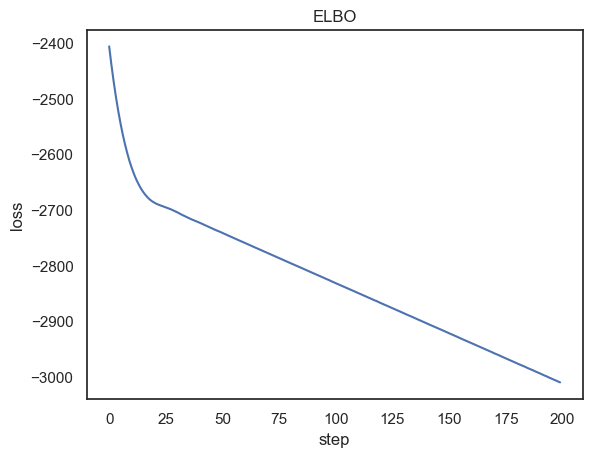

In [14]:
plot_loss(ll[0])


In [15]:
params = locate.learned_parameters_Clonal()

In [16]:
res = pd.DataFrame({'CN_Major':params["CN_Major"]+0.05,
                    'CN_minor':params["CN_minor"]-0.05,
                    'pos':[i for i in range(len(params["CN_minor"]))]})

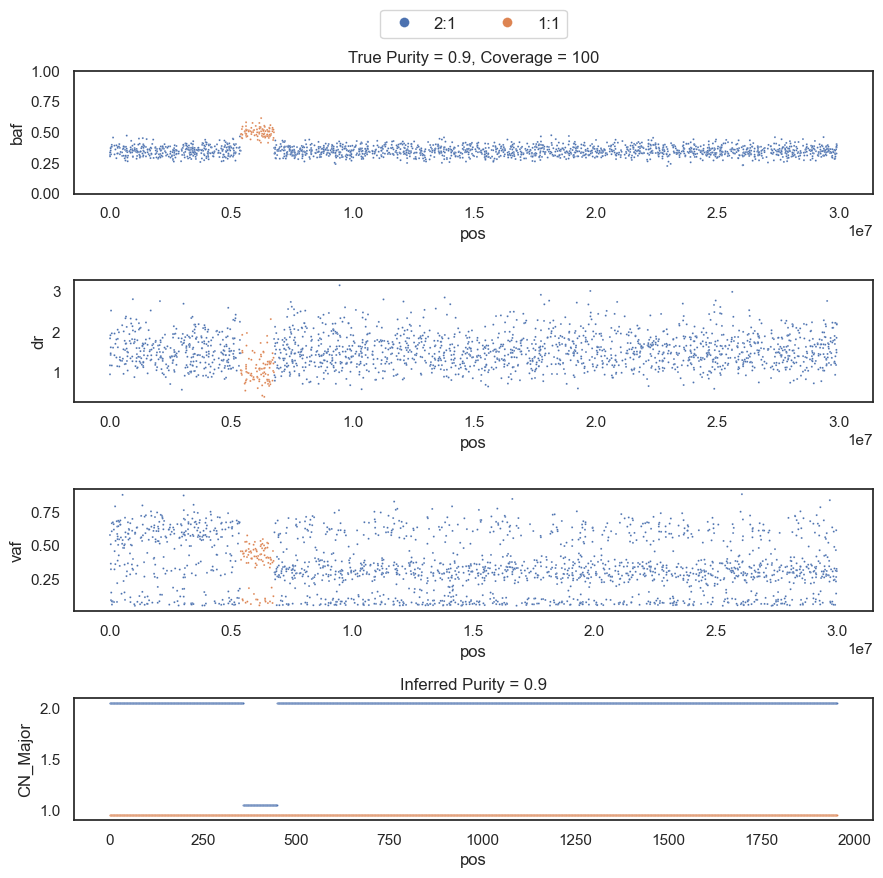

In [17]:
plot_results_simulations(snp, snv, res, params, purity, coverage)